# Baseline 2:

Staged Least Squares Instrumental Variables Regression using Cornelia's Medical Data

- Using instrumental variables and fixed effects shown here: https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit?usp=sharing
- Include control diagnoses.

---
### Step 1: Import packages

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.anova import anova_lm

import patsy
import sklearn.preprocessing as sklp
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

---
### Step 2: Define working directories and global variables

#### Hi Cornelia! Please have the following directories created ahead of time (data/ and output/ are your original ones; the remaining folders will be used to store the model outputs and relevant metadata we need to associate models to our instrument-and-FEs combinations). Thank you!
* data/
* output/
* models_s1/
* models_s2/
* fixed_effects/

#### 2.1. Set working directories

In [7]:
path = 'gdrive_tj'

if path == 'cornelia':

  in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
  in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'
  # folder containing stage 1 outputs
  out_dir1 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s1/'
  # folder containing stage 2 outputs
  out_dir2 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s2/'
  # folder containing csvs documenting which fixed effects are in which csv files
  out_dir3 = 'C:/Users/cilin/Research/CA_hospitals_capstone/fixed_effects/'

elif path == 'michelle':

  # #Michelle testing on her computer
  # in_dir_sc = '/Users/michelle/MIDS/210 Capstone/data/'
  # in_dir_h = '/Users/michelle/MIDS/210 Capstone/output/'

  # # folder containing stage 1 outputs
  # out_dir1 = '/Users/michelle/MIDS/210 Capstone/models_s1/'

  # # folder containing stage 2 outputs
  # out_dir2 = '/Users/michelle/MIDS/210 Capstone/models_s2/'

  # # folder containing csvs documenting which fixed effects are in which csv files
  # out_dir3 = '/Users/michelle/MIDS/210 Capstone/fixed_effects/'
  pass

elif path == 'gdrive_tj':
  
  from google.colab import drive
  drive.mount('/content/gdrive')
  # tj gdrive
  in_dir_sc = '/content/gdrive/MyDrive/w210/CA_hospitals_capstone/data/'
  in_dir_h = '/content/gdrive/MyDrive/w210/CA_hospitals_capstone/output/'
  # folder containing stage 1 outputs
  out_dir1 = '/content/gdrive/MyDrive/w210/CA_hospitals_capstone/models_s1/'
  # folder containing stage 2 outputs
  out_dir2 = '/content/gdrive/MyDrive/w210/CA_hospitals_capstone/models_s2/'
  # folder containing csvs documenting which fixed effects are in which csv files
  out_dir3 = '/content/gdrive/MyDrive/w210/CA_hospitals_capstone/fixed_effects/'


elif path == 'local_tj':
  main_path = '/Users/tj/trevor.johnson.tj@gmail.com - Google Drive/My Drive/w210/CA_hospitals_capstone'
  in_dir_sc = os.path.join(main_path, 'data')
  in_dir_h = os.path.join(main_path, 'output')
  out_dir1 = os.path.join(main_path, 'models_s1')      # folder containing stage 1 outputs
  out_dir2 = os.path.join(main_path, 'models_s2')      # folder containing stage 2 outputs
  out_dir3 = os.path.join(main_path, 'fixed_effects')  # folder containing csvs documenting which fixed

Mounted at /content/gdrive


#### 2.2. Set Instrumental Variable (predictor), Fixed Effects set, and Notebook Index
* Set the instrumental variable (predictor), fixed effects set, and unique notebook index (please don't change)

In [8]:
# set instrumental variable version
#predictor = 'Izmy_v3_normed_D_and_TPY'
predictor = 'Izmy_v4_nodist_normed_TPY'
#predictor = 'Izmy_v5_all_normed_but_wspd_ratio'
#predictor = 'Izmy_v7_all_normed_no_wspd'

# set FE to one of 8 sets (int)
FE_set_num = 7

# sets unique notebooks index (string - this is just to output a csv file name)
notebook_index = "diff16_no_outliers_fn_T"

# set option to filter outliers on medical outcomes data
filter_medical_outliers = True

#### 2.3. Specify which inputs and outputs we're looking at
* Specify the pm2.5 (target) name 
* Specify instrument (predictor) name
* Specify lead and lag times

In [9]:
lead_time = 9
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")
print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v4_nodist_normed_TPY_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


#### 2.4. Define fixed effects
* Define Fixed Effects based on the fixed effects set hardcoded in 2.2.

In [10]:
basics = " ~ county + month + year_trend * C(county_month)"
env = '+ avg_temp' + IV_lead_input + ' + avg_elevation_diff_m'

if FE_set_num == 1:
    # FE Set 1
    adds = ""
elif FE_set_num == 2:
    # FE Set 2
    adds = ' + ca_agi_per_returns + total_population'
elif FE_set_num == 3:
    # FE Set 3
    adds = ' + school_count + total_population'
elif FE_set_num == 4:
    # FE Set 4
    adds = ' + total_population + avg_count_ps_within_5km'
elif FE_set_num == 5:
    # FE Set 5
    adds = ' + ca_agi_per_returns'
elif FE_set_num == 6:
    # FE Set 6
    adds = ' + total_population'
elif FE_set_num == 7:
    # FE Set 7
    adds = ' + ca_agi_per_returns + total_population + avg_wspd_top_15_r' + str(lead_time)
elif FE_set_num == 8:
    # FE Set 8
    adds = ''
    env = ''

fixed_effects = basics + env + adds

print("basics:\n{}\n".format(basics))
print("env:\n{}\n".format(env))

print("Fixed effects are:\n{}".format(fixed_effects))

basics:
 ~ county + month + year_trend * C(county_month)

env:
+ avg_temp_r9 + avg_elevation_diff_m

Fixed effects are:
 ~ county + month + year_trend * C(county_month)+ avg_temp_r9 + avg_elevation_diff_m + ca_agi_per_returns + total_population + avg_wspd_top_15_r9


---
### Step 3: Define functions

In [11]:
def fit_ols(df, outcome, predictor, fixed_effects):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    # X = temp[['pm25']]
    X = temp[[predictor]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

In [12]:
def fit_1st_stage(df, pm_col, instr_col, fixed_effects):
    ''' First stage to check whether wfeI is a strong instrument for pm25I
    '''
    
    temp = df.copy()

    # create FE and interactions between FE and continous vars
    f = pm_col + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    X = temp[[instr_col]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', pm_col)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(fit_1st_stage.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            fit_1st_stage.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    # save pm25I_hat
    temp[pm_col+'_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']
    
    # save model
    results_label = "s1_" + notebook_index + "_PREDICTOR_" + instr_col +  "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + pm_col + "_LAG" + HO_lag_input + ".pkl"
    filename = os.path.join(out_dir1, results_label)
    fit_1st_stage.save(filename, remove_data=True)

    return temp

In [13]:
def fit_2sls(df, outcome, independent_var_name, fixed_effects):
    ''''''
    #independent_var_name example: 'pm25_hat'

    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # optional code to filter outliers
    if filter_medical_outliers:
        # print(f"Outcome: {outcome}")
        # display(temp[outcome].describe())
        old_row_count = temp.shape[0]

        #temp = temp[ np.abs(temp[outcome]-temp[outcome].mean()) <= min(3*temp[outcome].std(), 1000*int(lag_time)) ]
        temp = temp[ np.abs(temp[outcome]-temp[outcome].mean()) <= (3*temp[outcome].std()) ]
        new_row_count = temp.shape[0]
        print(f"Outliers (over 3 std away) were filtered out, We drop {old_row_count - new_row_count} rows.")
        #display(temp[outcome].describe())

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects #" ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    #X = temp[['pm25_hat']]
    X = temp[[independent_var_name]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

    # save outcome_hat
    temp[outcome+'_hat'] = model_a.get_prediction(X).summary_frame()['mean']

    # save model
    results_label = "s2_" + notebook_index + "_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + outcome + ".pkl"
    filename = os.path.join(out_dir2, results_label)
    model_a.save(filename, remove_data=True)

    return temp

---
### Step 4: Read and clean individual datasets

#### 4.1. Define the function to generate LEAD rolling windows on dataframe

In [15]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [6]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = rolling_periods

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int



#### 4.2. Read in non-medical data and medical data
* Make sure the .csv name starts with 'modeling'
* Generate rolling windows for non-medical data for instrumental variable
* Filter out 2018 data from both non-medica and medical data

In [16]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df_sc = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df_sc['patzip_year_month'] = df_sc.school_zip.astype(str) + '-' + df_sc.year.astype(str) + '-' + df_sc.month.astype(str)

# add instrumental variables rolling things here - looking at past data, so need 2000-2002 for previous avgs
cols_to_roll = [predictor,'avg_wspd_top_15','avg_temp']

rolling_periods = [lead_time]
df_sc, all_cols = roll_selected_cols(df=df_sc, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# drop if year >=2018
df_sc = df_sc[df_sc.year.le(2017)]

# print shape of data
print('Shape of data ', df_sc.shape)
df_sc.head(2)



Shape of data  (294897, 153)


,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1,NaN,NaN,NaN
1322,1322,1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.666667,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,2732

In [17]:
# medical data
df_h = pd.DataFrame()
df_h['patzip_year_month'] = df_sc.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_h
    df_h = df_h.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_h['year_h'] = df_h.patzip_year_month.str.split('-').str[1]
df_h = df_h[df_h.year_h.le('2017')]
df_h.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of data ', df_h.shape)

Shape of data  (294897, 6)


In [18]:
df_h.columns

Index(['patzip_year_month', 'visits_pediatric_vasculitis',
       'visits_hematopoietic_cancers', 'visits_type_1_diabetes',
       'visits_injuries_accidents', 'visits_resp_cardio'],
      dtype='object')

#### 4.3. Dynamically add 'y_' and lag times to the column names

In [19]:
# Get the list of outcome columns from the merged health dataset (df_h above)
num_visits_col_names = [i for i in list(df_h.columns) if 'visit' in i]
print("num_visits_col_names:\n{}\n".format(num_visits_col_names))

# y_col_names is used in Section 5.4.
y_col_names = ['y_' + i for i in num_visits_col_names]
print("y_col_names:\n{}\n".format(y_col_names))

# create a list of columns for outcome variables with health outcome lag window added
# y_col_names_lag is used in Step 7
y_col_names_lag = []
for i in y_col_names:
    new_name = i + HO_lag_input
    y_col_names_lag.append(new_name)

print("y_col_names_lag:\n{}".format(y_col_names_lag))

# create a list of columns for outcome variables with health outcome lag window added
y_col_names_lag_diff = []
for i in y_col_names_lag:
    new_name = i + '_diff_r12'
    y_col_names_lag_diff.append(new_name)

print("\ny_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))

num_visits_col_names:
['visits_pediatric_vasculitis', 'visits_hematopoietic_cancers', 'visits_type_1_diabetes', 'visits_injuries_accidents', 'visits_resp_cardio']

y_col_names:
['y_visits_pediatric_vasculitis', 'y_visits_hematopoietic_cancers', 'y_visits_type_1_diabetes', 'y_visits_injuries_accidents', 'y_visits_resp_cardio']

y_col_names_lag:
['y_visits_pediatric_vasculitis_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'y_visits_type_1_diabetes_fwd3', 'y_visits_injuries_accidents_fwd3', 'y_visits_resp_cardio_fwd3']

y_col_names_lag_diff:
['y_visits_pediatric_vasculitis_fwd3_diff_r12', 'y_visits_hematopoietic_cancers_fwd3_diff_r12', 'y_visits_type_1_diabetes_fwd3_diff_r12', 'y_visits_injuries_accidents_fwd3_diff_r12', 'y_visits_resp_cardio_fwd3_diff_r12']


---
### Step 5: Merge datasets and data preprocessing

#### 5.1. Merge non-medical and medical datasets

In [20]:
# merge df_h to df_sc
df_all = df_sc.merge(
    df_h,
    on='patzip_year_month',
    how='left'
)

# print shape of data
print('Shape of data ', df_all.shape)
df_all.head(2)

# Shape of data  (294897, 164) <-- old one

Shape of data  (294897, 158)


,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_pediatric_vasculitis,visits_hematopoietic_cancers,visits_type_1_diabetes,visits_injuries_accidents,visits_resp_cardio
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1322,1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.66666

#### 5.2. Fill in nulls conditionally on merged datasets

* For each health outcome, fill in the nulls for a zipcode with 0's ONLY if that row occurred after the first non-zero/not-null visit in that zipcode for that health outcome (keeps them as nulls otherwise)

In [21]:
def filter_nans(df, visits_cols = num_visits_col_names, replace_after_1 = True):
    """Function to generate columns in place that do one of two things
    
    If replace_after_1 == True, replacec NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.
    
    If replace_after_1 == False, replaces all NaNs with 0's if there exists any
    non-zero/not null visit in that zipcode for the specific health outcome. Keeps
    them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
        replace_after_1: Bool
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # If there is a nonzero/non-null, replace all NaNs after with 0's
        if replace_after_1 == True:
        # check the school zip first
            if dataset_row_idx < first_val_row_idx:
                orig_visits = orig_visits
            elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
                if pd.isnull(orig_visits):
                    orig_visits = 0
                else:
                    orig_visits = orig_visits
            return orig_visits

        # If there's a nonzero/non-null value at any point, replace all NaNs for that zipcode with 0's
        elif replace_after_1 == False:
            # in the event that there is no nonzero/non-null anywhere in the zip
            if zip_idx == df_grouped_schools.shape[0]:
                orig_visits = orig_visits
            # there is a 1.0 somewhere in the zip, change all NaNs to 0's
            else:
                if pd.isnull(orig_visits):
                    orig_visits = 0
                else: 
                    orig_visits = orig_visits
            return orig_visits

        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]

            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set value to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

# call function:
df_all = filter_nans(df_all, visits_cols = num_visits_col_names, replace_after_1 = True)
display(df_all)

,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_pediatric_vasculitis,visits_hematopoietic_cancers,visits_type_1_diabetes,visits_injuries_accidents,visits_resp_cardio
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1322,1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.6

#### 5.3. Create response variables

In [22]:
# Create response variables, which is visits / population
for col in num_visits_col_names:
    df_all['y_'+col] = 1000 * df_all[col] / df_all['total_pop_under19']
    
# add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df_all.year.unique()))}
df_all["year_trend"] = df_all.year.map(year_map)
df_all["year_trend"] = df_all.year_trend + 1

# create county_month 
df_all['county_month'] = df_all.school_county_v2 + '_' + df_all.month.astype(str)

# rename school_county_v2
df_all.rename(columns={'school_county_v2': 'county'}, inplace=True)

# reset index
df_all.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df_all.shape) # Old shape of data  (294897, 174)
df_all.head(2)

Shape of data  (294897, 165)


,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_pediatric_vasculitis,visits_hematopoietic_cancers,visits_type_1_diabetes,visits_injuries_accidents,visits_resp_cardio,y_visits_pediatric_vasculitis,y_visits_hematopoietic_cancers,y_visits_type_1_diabetes,y_visits_injuries_accidents,y_visits_resp_cardio,year_trend,county_month
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

#### 5.4. Generate LAG rolling windows on Health Outcomes

In [23]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [24]:
df_all = df_all.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_all.columns)

# 3 months ---
n = int(lag_time) # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']

# print columns added
ending_cols = list(df_all.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using {n} month window:\n{window_3months_columns}")
starting_cols = list(df_all.columns)


Columns added for health outcomes using 3 month window:
['visits_pediatric_vasculitis_fwd3', 'y_visits_pediatric_vasculitis_fwd3', 'visits_pediatric_vasculitis_cent3', 'y_visits_pediatric_vasculitis_cent3', 'visits_hematopoietic_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'visits_hematopoietic_cancers_cent3', 'y_visits_hematopoietic_cancers_cent3', 'visits_type_1_diabetes_fwd3', 'y_visits_type_1_diabetes_fwd3', 'visits_type_1_diabetes_cent3', 'y_visits_type_1_diabetes_cent3', 'visits_injuries_accidents_fwd3', 'y_visits_injuries_accidents_fwd3', 'visits_injuries_accidents_cent3', 'y_visits_injuries_accidents_cent3', 'visits_resp_cardio_fwd3', 'y_visits_resp_cardio_fwd3', 'visits_resp_cardio_cent3', 'y_visits_resp_cardio_cent3']


#### 5.5. Make the 12 month difference between health outcome columns

In [25]:
def y_outcome_difference_maker(df, y_variable_col_name, num_months_back):

  '''
  This function takes the 12 month difference of the health outcome. 

  We would use it after we make our y_visits_ columns in Cornelia's notebook on those columns. In stage 2, we use these columns as our y variable. 

  Fix Cornelia's 2sls script notebooks to use the y_visits that are there originally and then run and OLS on this difference column for it right underneath.
  '''
  df_copy = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)

  df_copy[f'{y_variable_col_name}_diff_r{num_months_back}'] = df_copy.groupby('school_zip')[y_variable_col_name]\
                                        .apply(lambda x:x - x.shift(num_months_back))

  print(f"Outcome generated: {y_variable_col_name}_diff_r{num_months_back}")
  return df_copy


In [26]:
# add the 12 month differences for the health outcomes
for var_name in y_col_names_lag:
    df_all = y_outcome_difference_maker(df_all, var_name, 12)

display(df_all)

Outcome generated: y_visits_pediatric_vasculitis_fwd3_diff_r12
Outcome generated: y_visits_hematopoietic_cancers_fwd3_diff_r12
Outcome generated: y_visits_type_1_diabetes_fwd3_diff_r12
Outcome generated: y_visits_injuries_accidents_fwd3_diff_r12
Outcome generated: y_visits_resp_cardio_fwd3_diff_r12


,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_pediatric_vasculitis,visits_hematopoietic_cancers,visits_type_1_diabetes,visits_injuries_accidents,visits_resp_cardio,y_visits_pediatric_vasculitis,y_visits_hematopoietic_cancers,y_visits_type_1_diabetes,y_visits_injuries_accidents,y_visits_resp_cardio,year_trend,county_month,visits_pediatric_vasculitis_fwd3,y_visits_pediatric_vasculitis_fwd3,visits_pediatric_vasculitis_cent3,y_visits_pediatric_vasculitis_cent3,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hematopoietic_cancers_cent3,visits_type_1_diabetes_fwd3,y_visits_type_1_diabetes_fwd3,visits_type_1_diabetes_cent3,y_visits_type_1_diabetes_cent3,visits_injuries_accidents_fwd3,y_visits_injuries_accidents_fwd3,visits_injuries_accidents_cent3,y_visits_injuries_accidents_cent3,visits_resp_cardio_fwd3,y_visits_resp_cardio_fwd3,visits_resp_cardio_cent3,y_visits_resp_cardio_cent3,y_visits_ped

#### 5.6. Show general statistics and outliers

In [27]:
# for our y variable: y_col_names_lag
for i in y_col_names_lag:
    print(f"Outcome: {i}")
    display(df_all[i].describe())

    #df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= min(3*df_all[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= (3*df_all[i].std()) ]
    j = df_all[~df_all[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_pediatric_vasculitis_fwd3


count    93064.000000
mean         0.917828
std          3.666329
min          0.000000
25%          0.000000
50%          0.000000
75%          1.096067
max        310.017095
Name: y_visits_pediatric_vasculitis_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 756 rows:


count    92308.000000
mean         0.696623
std          1.429485
min          0.000000
25%          0.000000
50%          0.000000
75%          1.046776
max         11.908198
Name: y_visits_pediatric_vasculitis_fwd3, dtype: float64


----

Outcome: y_visits_hematopoietic_cancers_fwd3


count    66363.000000
mean         1.690923
std          8.353952
min          0.000000
25%          0.000000
50%          0.000000
75%          1.679012
max        652.841782
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 527 rows:


count    65836.000000
mean         1.175206
std          2.544887
min          0.000000
25%          0.000000
50%          0.000000
75%          1.635401
max         26.678929
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3


count    65096.000000
mean         1.175000
std         18.508886
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2012.072435
Name: y_visits_type_1_diabetes_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 97 rows:


count    64999.000000
mean         0.837701
std          3.161133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.999157
Name: y_visits_type_1_diabetes_fwd3, dtype: float64


----

Outcome: y_visits_injuries_accidents_fwd3


count    134888.000000
mean        242.616329
std        1261.826569
min           0.000000
25%          25.053036
50%          49.039777
75%         178.200795
max      112000.000000
Name: y_visits_injuries_accidents_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 680 rows:


count    134208.000000
mean        193.343003
std         384.234482
min           0.000000
25%          24.930464
50%          48.747859
75%         173.268387
max        4005.308812
Name: y_visits_injuries_accidents_fwd3, dtype: float64


----

Outcome: y_visits_resp_cardio_fwd3


count    147106.000000
mean        226.125416
std        1177.493193
min           0.000000
25%          27.695648
50%          51.080057
75%         160.132263
max      112000.000000
Name: y_visits_resp_cardio_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 736 rows:


count    146370.000000
mean        178.806521
std         352.634322
min           0.000000
25%          27.597802
50%          50.789339
75%         156.327780
max        3750.000000
Name: y_visits_resp_cardio_fwd3, dtype: float64


----



In [28]:
# for 12 month difference columns: y_col_names_lag_diff
for i in y_col_names_lag_diff:
    print(f"Outcome: {i}")
    display(df_all[i].describe())

    #df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= min(3*df_all[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= (3*df_all[i].std()) ]
    j = df_all[~df_all[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_pediatric_vasculitis_fwd3_diff_r12


count    85945.000000
mean        -0.029637
std          4.478535
min       -310.017095
25%          0.000000
50%          0.000000
75%          0.000000
max        174.339478
Name: y_visits_pediatric_vasculitis_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 901 rows:


count    85044.000000
mean         0.028912
std          2.027662
min        -13.449367
25%          0.000000
50%          0.000000
75%          0.000000
max         13.335655
Name: y_visits_pediatric_vasculitis_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_hematopoietic_cancers_fwd3_diff_r12


count    59928.000000
mean        -0.392439
std          8.478895
min       -652.841782
25%         -0.080734
50%          0.000000
75%          0.021771
max        245.806825
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 657 rows:


count    59271.000000
mean        -0.107615
std          2.925823
min        -25.819033
25%         -0.057476
50%          0.000000
75%          0.019596
max         25.000000
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3_diff_r12


count    58082.000000
mean        -0.043293
std         18.122993
min      -2012.072435
25%          0.000000
50%          0.000000
75%          0.000000
max        326.923077
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 133 rows:


count    57949.000000
mean         0.124696
std          3.705210
min        -53.564227
25%          0.000000
50%          0.000000
75%          0.000000
max         53.178178
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_injuries_accidents_fwd3_diff_r12


count    125984.000000
mean         28.917158
std        1410.899260
min     -112000.000000
25%          -1.189393
50%           0.802742
75%           6.548772
max      112000.000000
Name: y_visits_injuries_accidents_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 589 rows:


count    125395.000000
mean         14.362938
std         366.799083
min       -4199.182460
25%          -1.178181
50%           0.798980
75%           6.425035
max        4257.611171
Name: y_visits_injuries_accidents_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_resp_cardio_fwd3_diff_r12


count    138202.000000
mean         17.160002
std        1207.875646
min     -112000.000000
25%          -2.029509
50%           0.475988
75%           7.186268
max       75000.000000
Name: y_visits_resp_cardio_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 734 rows:


count    137468.000000
mean         13.182843
std         326.058780
min       -3580.645161
25%          -2.005768
50%           0.473489
75%           7.080395
max        3631.844008
Name: y_visits_resp_cardio_fwd3_diff_r12, dtype: float64


----



#### 5.7. Filter out 2018 Data

In [29]:
#filter data to appropriate data range
df_all = df_all[df_all.year >= 2002]

print(min(df_all.year))
print(max(df_all.year))

2002
2017


In [30]:
df_all.head()

,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_pediatric_vasculitis,visits_hematopoietic_cancers,visits_type_1_diabetes,visits_injuries_accidents,visits_resp_cardio,y_visits_pediatric_vasculitis,y_visits_hematopoietic_cancers,y_visits_type_1_diabetes,y_visits_injuries_accidents,y_visits_resp_cardio,year_trend,county_month,visits_pediatric_vasculitis_fwd3,y_visits_pediatric_vasculitis_fwd3,visits_pediatric_vasculitis_cent3,y_visits_pediatric_vasculitis_cent3,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hematopoietic_cancers_cent3,visits_type_1_diabetes_fwd3,y_visits_type_1_diabetes_fwd3,visits_type_1_diabetes_cent3,y_visits_type_1_diabetes_cent3,visits_injuries_accidents_fwd3,y_visits_injuries_accidents_fwd3,visits_injuries_accidents_cent3,y_visits_injuries_accidents_cent3,visits_resp_cardio_fwd3,y_visits_resp_cardio_fwd3,visits_resp_cardio_cent3,y_visits_resp_cardio_cent3,y_visits_ped

#### 5.8. Displaying and checking the nulls in inputs

In [31]:
# EDA: Displays all nulls in the dataset
temp = df_all.isna().sum()
temp[temp > 0]


pm25_last_month                                     24
pm25_r6                                            146
pm25_r9                                            224
pm25_r12                                           302
pm25_r24                                          1065
pm25_slope6                                        146
pm25_slope9                                        224
pm25_slope12                                       302
pm25_slope24                                      1065
pm25_lag_12mo                                      302
Izmy_v4_nodist_normed_TPY_r9                       224
avg_wspd_top_15_r9                                 224
avg_temp_r9                                        224
visits_pediatric_vasculitis                     170004
visits_hematopoietic_cancers                    195437
visits_type_1_diabetes                          196486
visits_injuries_accidents                       131125
visits_resp_cardio                              125698
y_visits_p

In [32]:
# check if number of NAs in the predictor and target columns are the same 
temp.loc[[target_name_s1, predictor_name_s1]]

pm25_r9                         224
Izmy_v4_nodist_normed_TPY_r9    224
dtype: int64

#### 5.9. Save dataset with nulls filtered out of Instrumental Variables as new variable, `df_all_iv_filtered`, to use in Stage 1 regression

In [33]:
# filter out NAs 
df_all_iv_filtered = df_all.dropna(subset=[target_name_s1, predictor_name_s1])

In [34]:
# check that NAs were filtered out of dataframe
df_all_iv_filtered.isna().sum().loc[[target_name_s1, predictor_name_s1]]

pm25_r9                         0
Izmy_v4_nodist_normed_TPY_r9    0
dtype: int64

---
### Step 6: EDA

``pm25 and instrument``

In [35]:
df_all_iv_filtered

,Unnamed: 0,Unnamed: 0.1,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_pediatric_vasculitis,visits_hematopoietic_cancers,visits_type_1_diabetes,visits_injuries_accidents,visits_resp_cardio,y_visits_pediatric_vasculitis,y_visits_hematopoietic_cancers,y_visits_type_1_diabetes,y_visits_injuries_accidents,y_visits_resp_cardio,year_trend,county_month,visits_pediatric_vasculitis_fwd3,y_visits_pediatric_vasculitis_fwd3,visits_pediatric_vasculitis_cent3,y_visits_pediatric_vasculitis_cent3,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hematopoietic_cancers_cent3,visits_type_1_diabetes_fwd3,y_visits_type_1_diabetes_fwd3,visits_type_1_diabetes_cent3,y_visits_type_1_diabetes_cent3,visits_injuries_accidents_fwd3,y_visits_injuries_accidents_fwd3,visits_injuries_accidents_cent3,y_visits_injuries_accidents_cent3,visits_resp_cardio_fwd3,y_visits_resp_cardio_fwd3,visits_resp_cardio_cent3,y_visits_resp_cardio_cent3,y_visits_ped

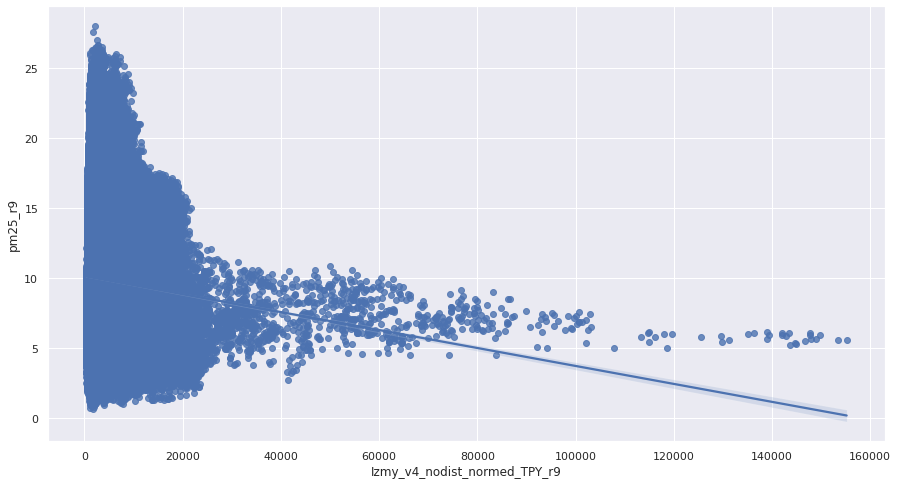

In [37]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.regplot(
    data=df_all_iv_filtered, 
    x='Izmy_v4_nodist_normed_TPY_r9',
    y='pm25_r9'
)

In [38]:
# f test
y, X_null = dmatrices('pm25_r9 ~ 1', data=df_all_iv_filtered, return_type='dataframe')
y, X_instrument = dmatrices('pm25_r9 ~ 1 + Izmy_v4_nodist_normed_TPY_r9', data=df_all_iv_filtered, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,262449.0,4.934512e+06,0.0,NaN,NaN,NaN
1,262448.0,4.909913e+06,1.0,24599.045777,1314.884877,3.407971e-287


In [58]:
# covariance first principals
covar1 = np.sum((df_all_iv_filtered['pm25_r9'].values - df_all_iv_filtered['pm25_r9'].mean()) * (df_all_iv_filtered['Izmy_v4_nodist_normed_TPY_r9'].values - df_all_iv_filtered['Izmy_v4_nodist_normed_TPY_r9'].mean())) / (df_all_iv_filtered.shape[0] - 1)
print(f'Covariance between I and X: {covar1:.1f}')

# covariance w/ numpy
covar2 = np.cov(df_all_iv_filtered['pm25_r9'].values, df_all_iv_filtered['Izmy_v4_nodist_normed_TPY_r9'].values)
print(f'Covariance between I and X: {covar2[0][1]:.1f}')

Covariance between I and X: -1461.3
Covariance between I and X: -1461.3


In [62]:
# correlation first principals
corr1 = covar1 / (np.std(df_all_iv_filtered['pm25_r9'].values) * np.std(df_all_iv_filtered['Izmy_v4_nodist_normed_TPY_r9'].values))
print(f'Correlation between I and X: {corr1:.6f}')

# using numpy
corr2 = np.corrcoef(df_all_iv_filtered['pm25_r9'].values, df_all_iv_filtered['Izmy_v4_nodist_normed_TPY_r9'].values)
print(f'Correlation between I and X: {corr2[0][1]:.6f}')

Correlation between I and X: -0.070606
Correlation between I and X: -0.070605


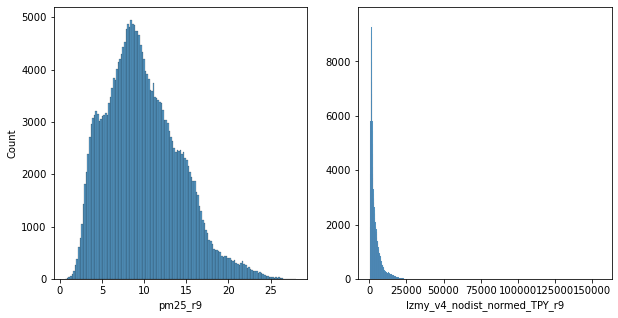

In [ ]:
#columns = ['pm25', 'avg_wind_alignment_cosine'] # hardcoded previously but made dynamically
columns = [target_name_s1, predictor_name_s1]


# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    
    if idx in [0]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

``health outcomes``

In [ ]:
print(y_col_names)

['y_visits_all_malignant_cancers', 'y_visits_all_nonblood_malignant_cancers', 'y_visits_blood_diseases', 'y_visits_blood_or_bv_diseases', 'y_visits_blood_vessel_diseases', 'y_visits_cardioresp_cancers', 'y_visits_hematopoietic_cancers', 'y_visits_injuries', 'y_visits_respiratory', 'y_visits_type_1_diabetes']


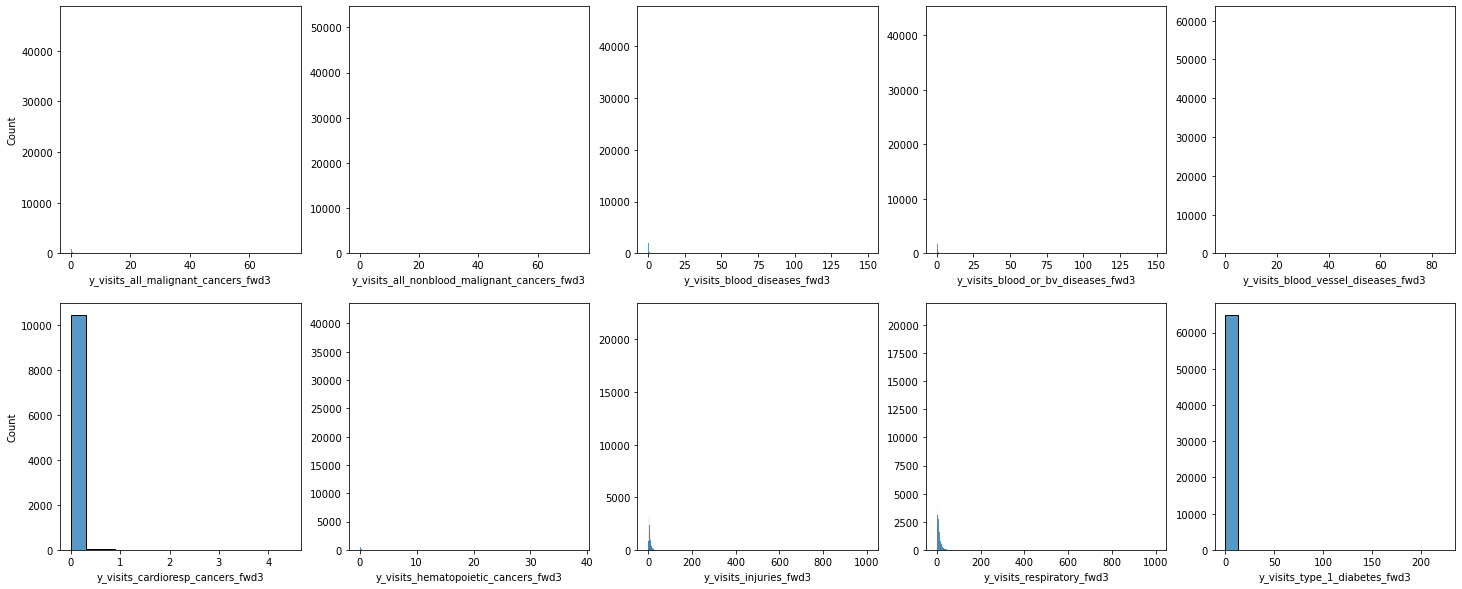

In [ ]:
#columns = df_h.columns[1:]
columns = y_col_names_lag

# compute visits by patzip_year_month
fig, axes = plt.subplots(int(len(columns)/5), 5, sharex=False, sharey=False, figsize=(25, int(len(columns))))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    if idx in [0, 5]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

In [ ]:
# columns = y_col_names_lag_diff

# # compute visits by patzip_year_month
# fig, axes = plt.subplots(int(len(columns)/5), 5, sharex=False, sharey=False, figsize=(25, int(len(columns))))

# for idx, ax in enumerate(axes.flatten()):
#     sb.histplot(
#             df_all_iv_filtered[columns[idx]],
#             ax=ax
#         )
#     if idx in [0, 5]:
#         ax.set_ylabel('Count')
#     else:
#         ax.set_ylabel(' ')

---
### Step 7: Analysis - linear modeling

#### 7.1. Check outcome_hat columns
* Make sure that the format contains the lag

In [ ]:
# verify names of columns + lag we're going to use
print("y_col_names_lag:\n{}".format(y_col_names_lag))
print("y_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))


y_col_names_lag:
['y_visits_all_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_blood_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_fwd3', 'y_visits_respiratory_fwd3', 'y_visits_type_1_diabetes_fwd3']
y_col_names_lag_diff:
['y_visits_all_malignant_cancers_fwd3_diff_r12', 'y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12', 'y_visits_blood_diseases_fwd3_diff_r12', 'y_visits_blood_or_bv_diseases_fwd3_diff_r12', 'y_visits_blood_vessel_diseases_fwd3_diff_r12', 'y_visits_cardioresp_cancers_fwd3_diff_r12', 'y_visits_hematopoietic_cancers_fwd3_diff_r12', 'y_visits_injuries_fwd3_diff_r12', 'y_visits_respiratory_fwd3_diff_r12', 'y_visits_type_1_diabetes_fwd3_diff_r12']


#### 7.2. ``fit ols``

In [ ]:
for col in y_col_names_lag:
    fit_ols(df_all_iv_filtered, col, target_name_s1, fixed_effects)

Outcome:  y_visits_all_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.001084,0.003235,-0.005417,0.007584,0.739071
1,Intercept,0.050164,0.241069,-0.434283,0.534610,0.836023


Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.001819,0.003661,-0.005543,0.009180,0.621630
1,Intercept,-0.072303,0.229115,-0.532970,0.388364,0.753694


Outcome:  y_visits_blood_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.006284,0.003239,-0.000224,0.012792,0.058090
1,Intercept,0.029560,0.117334,-0.206232,0.265351,0.802152


Outcome:  y_visits_blood_or_bv_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.005419,0.002983,-0.000573,0.011410,0.075276
1,Intercept,0.006674,0.127545,-0.249508,0.262856,0.958478


Outcome:  y_visits_blood_vessel_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.001843,0.001117,-0.004088,0.000402,0.105340
1,Intercept,-0.018103,0.085597,-0.190208,0.154002,0.833399


Outcome:  y_visits_cardioresp_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.002560,0.001172,-0.004962,-0.000159,0.037515
1,Intercept,0.071454,0.029999,0.010004,0.132904,0.024258


Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.003142,0.002363,-0.007894,0.001610,0.189970
1,Intercept,0.352092,0.177887,-0.005574,0.709758,0.053533


Outcome:  y_visits_injuries_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.022870,0.040392,-0.103961,0.058221,0.57374
1,Intercept,-5.760092,2.002196,-9.779669,-1.740515,0.00585


Outcome:  y_visits_respiratory_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.016333,0.067898,-0.152643,0.119977,0.810867
1,Intercept,-10.743688,3.074762,-16.916529,-4.570846,0.000993


Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.001232,0.003226,-0.005255,0.007719,0.704247
1,Intercept,-0.160250,0.366828,-0.897807,0.577306,0.664176


In [ ]:
for col in y_col_names_lag_diff:
    fit_ols(df_all_iv_filtered, col, target_name_s1, fixed_effects)

Outcome:  y_visits_all_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.006765,0.004569,-0.002417,0.015947,0.145108
1,Intercept,-0.220972,0.188543,-0.599863,0.157920,0.246866


Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002798,0.002070,-0.001364,0.006961,0.182848
1,Intercept,-0.086075,0.119626,-0.326600,0.154449,0.475299


Outcome:  y_visits_blood_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002911,0.002416,-0.001947,0.007768,0.234167
1,Intercept,0.007704,0.078949,-0.151033,0.166441,0.922669


Outcome:  y_visits_blood_or_bv_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002378,0.002624,-0.002896,0.007651,0.369314
1,Intercept,0.043163,0.099195,-0.156177,0.242502,0.665380


Outcome:  y_visits_blood_vessel_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000347,0.001561,-0.002793,0.003486,0.825206
1,Intercept,0.032808,0.091977,-0.152124,0.217739,0.722884


Outcome:  y_visits_cardioresp_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000784,0.001043,-0.001357,0.002925,0.458788
1,Intercept,-0.000658,0.039735,-0.082189,0.080872,0.986900


Outcome:  y_visits_hematopoietic_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.005173,0.003515,-0.001893,0.012240,0.147571
1,Intercept,-0.340228,0.219346,-0.781252,0.100796,0.127446


Outcome:  y_visits_injuries_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.007917,0.030302,-0.052916,0.068750,0.794940
1,Intercept,-1.287223,1.057656,-3.410556,0.836111,0.229186


Outcome:  y_visits_respiratory_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.053091,0.029244,-0.111800,0.005618,0.075332
1,Intercept,1.269202,1.395074,-1.531525,4.069930,0.367221


Outcome:  y_visits_type_1_diabetes_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.003760,0.002858,-0.001987,0.009508,0.194614
1,Intercept,-0.519733,0.304149,-1.131266,0.091800,0.093946


#### 7.3. ``fit Stage 1``
* The function `fit_1st_stage` is in "Step 3: Define functions" in this notebook; added functionality within that function to output the model object in .pkl form to the directory called models_s1/

In [ ]:
df_all_iv_filtered = fit_1st_stage(df_all_iv_filtered, target_name_s1, predictor_name_s1, fixed_effects)


Outcome:  pm25_r9
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,Izmy_v4_nodist_normed_TPY_r9,-0.000107,0.000019,-0.000145,-0.000070,4.020117e-07
1,Intercept,15.698547,2.217056,11.258968,20.138126,2.333666e-09


In [ ]:
display(df_all_iv_filtered[[target_name_s1, target_name_s1 + '_hat']])

,pm25_r9,pm25_r9_hat
24,21.916667,19.755650
25,22.851852,20.413617
26,23.625926,20.209175
27,23.583333,20.091080
28,23.418518,19.532481
...,...,...
294892,2.942708,3.368566
294893,3.102431,3.515874
294894,3.113194,3.544151
294895,3.397917,3.742102


#### 7.4. Save Stage 1 dataset (csv + parquet)
Don't worry, Cornelia, these datasets only contain our own features and predictions - we dropped your true health data columns earlier!

In [ ]:
# Drops all health-data-related columns before saving
saved_stage1 = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

In [ ]:
# Check that there are no longer any health-data-related columns in the dataset (should return empty list)
[i for i in saved_stage1.columns if 'visit' in i]

[]

In [ ]:
# Saving out datasets
saved_stage1_name = "s1_" + notebook_index + "_PREDICTOR_" + predictor_name_s1 +  "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + target_name_s1 + "_LAG" + HO_lag_input
saved_stage1.to_csv(os.path.join(out_dir1, saved_stage1_name + ".csv"))
saved_stage1.to_parquet(os.path.join(out_dir1, saved_stage1_name + ".parquet"))

#### 7.5. Plot counts per pm2.5r# and pm2.5r#_hat

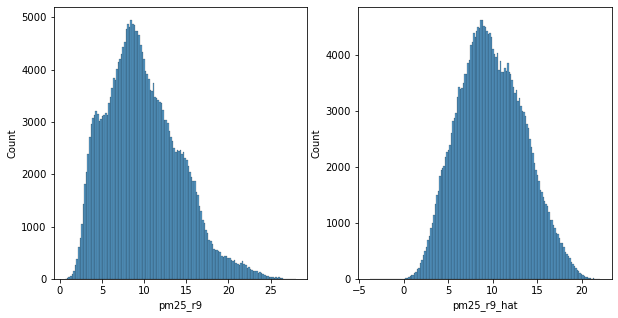

In [ ]:
columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )

#### 7.6. Stage 1 F-test:

Run an F test with our instrument to study the impact on the pm2.5. 

In [ ]:
# get data into right model form

y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_all_iv_filtered, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_all_iv_filtered, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,262449.0,4.934512e+06,0.0,NaN,NaN,NaN
1,262448.0,4.909913e+06,1.0,24599.045777,1314.884877,3.407971e-287


#### 7.7. ``fit 2sls``
* Fits the stage 2 linear regression
* The function `2sls` is in "Step 3: Define functions" in this notebook; added functionality within that function to output the model object in .pkl form to the directory called models_s2/
* Generates dataset after dropping the real health outcomes values (so we're only saving the predicted values)

In [ ]:
list_of_stage2_saves = []
saved_stage1_copy = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

# Merging predicted outcome variables (taken from subsetting the fit_2sls function output dataset) with original dataset (minus visits columns)
for col in y_col_names_lag:
    s2_df = fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)
    
    # subset to have join keys and new columns (e.g. 'y_visits_hematopoietic_cancers_fwd3_hat') only
    outcome_hat = s2_df[['year_month', 'school_zip', col+"_hat"]]
    saved_stage1_copy = pd.merge(saved_stage1_copy, outcome_hat, how='left', left_on=['year_month', 'school_zip'], right_on=['year_month', 'school_zip'])
    rmse_val = np.mean(((df_all_iv_filtered[col] - saved_stage1_copy[col+'_hat'])**2)**.5)
    print('RMSE for {} and {}: {}'.format(col, col+'_hat', rmse_val))



Outliers (over 3 std away) were filtered out, We drop 677 rows.
Outcome:  y_visits_all_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.017573,0.006405,0.004702,0.030445,0.008466
1,Intercept,-0.270554,0.146910,-0.565781,0.024672,0.071586


RMSE for y_visits_all_malignant_cancers_fwd3 and y_visits_all_malignant_cancers_fwd3_hat: 0.26876607068535624
Outliers (over 3 std away) were filtered out, We drop 422 rows.
Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.008579,0.005386,-0.002251,0.019409,0.117792
1,Intercept,-0.135203,0.109072,-0.354508,0.084101,0.221159


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_all_nonblood_malignant_cancers_fwd3 and y_visits_all_nonblood_malignant_cancers_fwd3_hat: 0.16389290025894185
Outliers (over 3 std away) were filtered out, We drop 640 rows.
Outcome:  y_visits_blood_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.008929,0.007065,-0.023134,0.005275,0.212353
1,Intercept,0.161429,0.139380,-0.118813,0.441671,0.252514


RMSE for y_visits_blood_diseases_fwd3 and y_visits_blood_diseases_fwd3_hat: 0.35798997450896697
Outliers (over 3 std away) were filtered out, We drop 640 rows.
Outcome:  y_visits_blood_or_bv_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.006027,0.008089,-0.022283,0.010230,0.459832
1,Intercept,0.074925,0.157664,-0.241914,0.391763,0.636744


RMSE for y_visits_blood_or_bv_diseases_fwd3 and y_visits_blood_or_bv_diseases_fwd3_hat: 0.42738966932412736
Outliers (over 3 std away) were filtered out, We drop 253 rows.
Outcome:  y_visits_blood_vessel_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.004827,0.006383,-0.017662,0.008007,0.453193
1,Intercept,0.026691,0.112884,-0.200277,0.253659,0.814091


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_blood_vessel_diseases_fwd3 and y_visits_blood_vessel_diseases_fwd3_hat: 0.11347335587776933
Outliers (over 3 std away) were filtered out, We drop 91 rows.
Outcome:  y_visits_cardioresp_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.001601,0.003411,-0.005386,0.008589,0.642360
1,Intercept,-0.044494,0.060643,-0.168715,0.079727,0.469226


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_cardioresp_cancers_fwd3 and y_visits_cardioresp_cancers_fwd3_hat: 0.018834010300010563
Outliers (over 3 std away) were filtered out, We drop 497 rows.
Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.006019,0.009809,-0.013703,0.025742,0.542355
1,Intercept,-0.037175,0.166304,-0.371551,0.297201,0.824065


RMSE for y_visits_hematopoietic_cancers_fwd3 and y_visits_hematopoietic_cancers_fwd3_hat: 0.1655367134404454
Outliers (over 3 std away) were filtered out, We drop 674 rows.
Outcome:  y_visits_injuries_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.092464,0.196615,-0.487185,0.302257,0.640161
1,Intercept,-2.257885,3.072214,-8.425612,3.909842,0.465744


RMSE for y_visits_injuries_fwd3 and y_visits_injuries_fwd3_hat: 5.613983096091616
Outliers (over 3 std away) were filtered out, We drop 1007 rows.
Outcome:  y_visits_respiratory_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.769913,0.426684,-1.626516,0.086690,0.077073
1,Intercept,4.836565,7.125897,-9.469270,19.142401,0.500377


RMSE for y_visits_respiratory_fwd3 and y_visits_respiratory_fwd3_hat: 8.120679837934095
Outliers (over 3 std away) were filtered out, We drop 76 rows.
Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.005582,0.011641,-0.017825,0.028988,0.633787
1,Intercept,-0.265694,0.232099,-0.732361,0.200973,0.257992


RMSE for y_visits_type_1_diabetes_fwd3 and y_visits_type_1_diabetes_fwd3_hat: 0.1077050311639245


In [ ]:
# Repeat using y_col_names_lag_diff
for col in y_col_names_lag_diff:
    s2_df = fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)
    
    # subset to have join keys and new columns (e.g. 'y_visits_hematopoietic_cancers_fwd3_hat') only
    outcome_hat = s2_df[['year_month', 'school_zip', col, col+"_hat"]]
    saved_stage1_copy = pd.merge(saved_stage1_copy, outcome_hat, how='left', left_on=['year_month', 'school_zip'], right_on=['year_month', 'school_zip'])
    rmse_val = np.mean(((df_all_iv_filtered[col] - saved_stage1_copy[col+'_hat'])**2)**.5)
    print('RMSE for {} and {}: {}'.format(col, col+'_hat', rmse_val))

Outliers (over 3 std away) were filtered out, We drop 767 rows.
Outcome:  y_visits_all_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.007882,0.003681,0.000484,0.015279,0.037277
1,Intercept,-0.138776,0.078479,-0.296485,0.018934,0.083233


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_all_malignant_cancers_fwd3_diff_r12 and y_visits_all_malignant_cancers_fwd3_diff_r12_hat: 0.29369524261567914
Outliers (over 3 std away) were filtered out, We drop 468 rows.
Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.001287,0.003542,-0.008408,0.005834,0.717910
1,Intercept,0.009450,0.067881,-0.127034,0.145933,0.889868


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12 and y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12_hat: 0.18033284811163708
Outliers (over 3 std away) were filtered out, We drop 1332 rows.
Outcome:  y_visits_blood_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.005300,0.003445,-0.012227,0.001627,0.130521
1,Intercept,0.175349,0.072290,0.030000,0.320698,0.019091


RMSE for y_visits_blood_diseases_fwd3_diff_r12 and y_visits_blood_diseases_fwd3_diff_r12_hat: 0.35975038920313257
Outliers (over 3 std away) were filtered out, We drop 1126 rows.
Outcome:  y_visits_blood_or_bv_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.001209,0.003766,-0.008777,0.006359,0.749602
1,Intercept,0.088970,0.077550,-0.066872,0.244812,0.256844


RMSE for y_visits_blood_or_bv_diseases_fwd3_diff_r12 and y_visits_blood_or_bv_diseases_fwd3_diff_r12_hat: 0.4133642613096989
Outliers (over 3 std away) were filtered out, We drop 220 rows.
Outcome:  y_visits_blood_vessel_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.007720,0.002876,0.001939,0.013502,0.009933
1,Intercept,-0.127638,0.057948,-0.244151,-0.011126,0.032455


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_blood_vessel_diseases_fwd3_diff_r12 and y_visits_blood_vessel_diseases_fwd3_diff_r12_hat: 0.11921220725013314
Outliers (over 3 std away) were filtered out, We drop 79 rows.
Outcome:  y_visits_cardioresp_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.002496,0.002993,-0.003657,0.008648,0.412012
1,Intercept,-0.040888,0.043225,-0.129738,0.047963,0.352897


RMSE for y_visits_cardioresp_cancers_fwd3_diff_r12 and y_visits_cardioresp_cancers_fwd3_diff_r12_hat: 0.0270143793000222
Outliers (over 3 std away) were filtered out, We drop 620 rows.
Outcome:  y_visits_hematopoietic_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.007820,0.006394,-0.005037,0.020676,0.227336
1,Intercept,-0.229384,0.117834,-0.466306,0.007537,0.057440


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_hematopoietic_cancers_fwd3_diff_r12 and y_visits_hematopoietic_cancers_fwd3_diff_r12_hat: 0.18234106798564123
Outliers (over 3 std away) were filtered out, We drop 673 rows.
Outcome:  y_visits_injuries_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.010387,0.062026,-0.114136,0.134910,0.867665
1,Intercept,-0.193599,1.070554,-2.342826,1.955628,0.857210


RMSE for y_visits_injuries_fwd3_diff_r12 and y_visits_injuries_fwd3_diff_r12_hat: 3.037776055385678
Outliers (over 3 std away) were filtered out, We drop 950 rows.
Outcome:  y_visits_respiratory_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.294274,0.080376,-0.455635,-0.132914,0.000596
1,Intercept,5.627970,1.524225,2.567960,8.687979,0.000542


RMSE for y_visits_respiratory_fwd3_diff_r12 and y_visits_respiratory_fwd3_diff_r12_hat: 4.0890092096828194
Outliers (over 3 std away) were filtered out, We drop 81 rows.
Outcome:  y_visits_type_1_diabetes_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.003826,0.005317,-0.006865,0.014517,0.475311
1,Intercept,-0.115510,0.100586,-0.317752,0.086732,0.256508


RMSE for y_visits_type_1_diabetes_fwd3_diff_r12 and y_visits_type_1_diabetes_fwd3_diff_r12_hat: 0.10231460242715062


#### 7.8. Save Stage 2 dataset
* Contains: all pm2.5r#, pm2.5r#_hat, outcome_hats, all instruments

In [ ]:
# saves stage 2 datasets (minus any visits columns) as csv and parquet

s2_dataset_out_name = "s2_" + notebook_index + "_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + "all_outcomes" + "_LAG" + HO_lag_input
saved_stage1_copy.to_csv(os.path.join(out_dir2, s2_dataset_out_name + ".csv"))
saved_stage1_copy.to_parquet(os.path.join(out_dir2, s2_dataset_out_name + ".parquet"))

#### 7.9. Generate dataset with name of the notebook, the stage 1 and stage 2 model and corresponding fixed effects (csv)
* Generates a csv that associates an instrument-plus-fixed-effects combo with the filenames of S1 and S2 datasets that we wrote out (doesn't include any columns with real outcome/visit data)

In [ ]:
csv_name = 'fixed_effects_' + notebook_index + '.csv'
FE_df_data = [[notebook_index, predictor, fixed_effects, saved_stage1_name+'.csv', s2_dataset_out_name+'.csv']]
FE_df = pd.DataFrame(data=FE_df_data, columns=['notebook_idx', 'instrument_name', 'fixed_effects_list', 's1_filename', 's2_filename'])
display(FE_df)

,notebook_idx,instrument_name,fixed_effects_list,s1_filename,s2_filename
0,diff16_no_outliers_fn_T,Izmy_v4_nodist_normed_TPY,~ county + month + year_trend * C(county_mont...,s1_diff16_no_outliers_fn_T_PREDICTOR_Izmy_v4_n...,s2_diff16_no_outliers_fn_T_INSTRUMENT_Izmy_v4_...


In [ ]:
# Write out to csv
FE_df.to_csv(os.path.join(out_dir3, csv_name))